# Image Segmentation

**Notebook currently compatible with the `NCI` environment only**

This is due to the package rsgislib not currently being installed on the DEA Sandbox. Rsgislib cannot be installed on the sandbox until conda is implemented.

### Background
In the last two decades, as the spatial resolutions of satellite images has increased, remote sensing has begun to shift from a focus on pixel-based analysis towards Geographic Object-Based Image Analysis (GEOBIA), which aims to group pixels together into meaningful image-objects. There are two advantages to a GEOBIA worklow; one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but meaningful objects. A review of the emerging trends in GEOBIA can be found [here](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

### Description
This notebook demonstrates a number of methods for conducting `image segmentation`, which is a common image analysis technique used to transform a digital satellite image into objects. In brief, [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) aims to partition an image into segments, where each segment consists of a group of pixels with similar characteristics. A number of algorithms exist to perform image segmentation, two of which are shown here:

1. [Shepherd Segmentation](https://www.mdpi.com/2072-4292/11/6/658), implemented through the package `rsgislib`
2. [Quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift), implemented through the python package `scikit-image`

### Technical details
* **Products used:** `ls8`
* **Analyses used:** `Image segmentation`
* **Special requirements:** 

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [63]:
%matplotlib inline

import xarray as xr
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import datacube
from datacube.helpers import write_geotiff
from skimage.segmentation import quickshift
import scipy

# import rsgislib
# from rsgislib.segmentation import meanImage
import dill
from pathos.multiprocessing import ProcessingPool as Pool
import sys

sys.path.append('../Scripts')
from dea_datahandling import array_to_geotiff
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_bandindices import calculate_indices
# import tiledSegParallel

### Connect to the datacube

In [2]:
# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc_landsat = datacube.Datacube(app='Image_segmentation', env='c3-samples')
except:
    dc_landsat = datacube.Datacube(app='Image_segmentation')

## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API using the [load_ard](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Using_load_ard.ipynb) function. This will provide us with some data to work with.

In [4]:
# Create a query object
query = {
    'x': (153.35, 153.50),
    'y': (-28.80, -28.95),
    'time': ('2018-01', '2018-12'),
    'measurements': ['nbart_red', 'nbart_nir'],
    'output_crs': 'EPSG:3577',
    'resolution': (-25, 25),
    'group_by': 'solar_day'
}

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc_landsat, 
              products=['ga_ls8c_ard_3'], 
              **query)
# Print output data
print(ds)

Loading ga_ls8c_ard_3 data
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 23 observations 
<xarray.Dataset>
Dimensions:    (time: 23, x: 684, y: 761)
Coordinates:
  * y          (y) float64 -3.3e+06 -3.3e+06 -3.3e+06 ... -3.319e+06 -3.319e+06
  * x          (x) float64 2.047e+06 2.047e+06 2.047e+06 ... 2.064e+06 2.064e+06
  * time       (time) datetime64[ns] 2018-01-03T23:42:39.393181 ... 2018-12-21T23:42:23.873255
Data variables:
    nbart_red  (time, y, x) float32 1307.0 999.0 694.0 769.0 ... nan nan nan nan
    nbart_nir  (time, y, x) float32 4414.0 4987.0 5309.0 5082.0 ... nan nan nan
Attributes:
    crs:      EPSG:3577


## Combine observations into a noise-free statistical summary image
Individual remote sensing images can be affected by noisy and incomplete data (e.g. due to clouds). To produce cleaner images that we can feed into the image segmentation algorithms, we can create summary images, or `composites,` that combine multiple images into one image to reveal the 'typical' appearance of the landscape for a certain time period.  In the code below, we take the noisy, incomplete satellite images we just loaded and calculate a mean Normalised Difference Vegetation Index (NDVI).  The mean NDVI will be our input into the segmentation algorithms. We will write the NDVI composite to a geotiff, as the Shepherd Segmentation operates on files on disk.

### Calculate mean NDVI

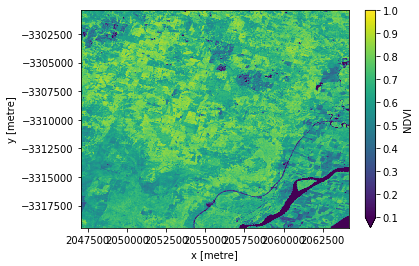

In [38]:
# first we calculate NDVI on each image in the timeseries
ndvi = calculate_indices(ds,
                  index='NDVI',
                  collection='ga_ls_3')

# For each pixel, calculate the mean NDVI throughout the whole time-series.
ndvi = ndvi.mean(dim='time', keep_attrs=True)

# #plot the results to inspect
ndvi.NDVI.plot(vmin=0.1, vmax=1.0)

### Write to geotiff

see this [notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Exporting_geotiffs.ipynb) for more info on writing geotiffs to file

In [39]:
write_geotiff('meanNDVI.tif', ndvi[['NDVI']])

## Shepherd Segmentation

Here we conduct an image segmentation on the geomedian geotiff we just wrote to file.  The cell directly below sets up the inputs to the [runShepherdSegmentation](https://www.rsgislib.org/rsgislib_segmentation.html) function. We then convert the geotiff to a .kea file using `gdal.Translate` (the .kea file format provides a full implementation of the GDAL data model and is implemented within a HDF5 file). The final cell will perform the segmentation on the .kea file. 

The `runShepherdSegmentation` function will output a .kea file containing the segmented image (you can open a .kea file using _xarray.open_rasterio_), along with a segmented geotiff populated with the zonal mean of the input geotiff.

To understand the parameters of the runShepheredSegmentation algorithm, read [here](https://www.rsgislib.org/rsgislib_segmentation.html)

In [ ]:
# Location string of the geotiff you wish to segment
tiff_input = 'meanNDVI.tif' 
# Location string of the .kea file the geotiff will be converted too
kea_file = 'meanNDVI.kea'
# Location string of segments .kea file that will be output 
SegmentedKEAFile = 'meanNDVI_segmented.kea'
# Location string of the segments zonal mean of input tiff
segments_zonal_mean = 'segments_zonal_mean.tif'

In [ ]:
#Convert the geotiff into a KEA file format
gdal.Translate(destName = kea_file, 
                   srcDS = tiff_input,
                   format='KEA',
                   outputSRS='EPSG:3577')

In [ ]:
#run the image segmentation
segutils.runShepherdSegmentation(inputImg = KEAFile, 
                                 outputClumps = SegmentedKEAFile,
                                 outputMeanImg = segments_zonal_mean,
                                 numClusters=20,
                                 minPxls=100)

## Quickshift Segmentation

Using the function [quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) from the python package scikit-image, we will conduct an image segmentation on the xarray dataset we loaded earlier.  We then calculate a zonal mean across each segment using the input dataset.  Because the quickshift algorithm requires a simple numpy ndarray as an input, out last step is to rebuild an xarray dataset and export our results as a geotiff.

Follow the quickshift hyperlink above to see the input parameters to the algorithm, and the following [link](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) for an explanation of quickshift and other segmentation algorithms in scikit-image

In [60]:
#convert our mean NDVI xarray into a numpy array 
input_array = ndvi.NDVI.values.astype(np.float64)

In [61]:
#calculate the segments
segments = quickshift(input_array,
                      kernel_size=5,
                      convert2lab=False,
                      max_dist=10,
                      ratio=1.0)

In [65]:
#calculate the zonal mean NDVI across the segments
segments_zonal_mean = scipy.ndimage.mean(input=input_array, labels=segments, index=segments)

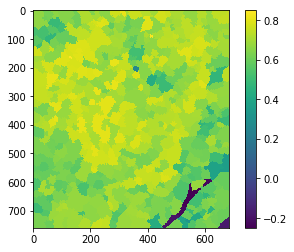

In [86]:
#plot to see result
plt.imshow(segments_zonal_mean)
plt.colorbar()

### Write result to geotiff

see this [notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Exporting_geotiffs.ipynb) for more info on writing geotiffs to file

In [101]:
transform = ds.geobox.transform.to_gdal()
projection = ds.geobox.crs.wkt

# Export the array
array_to_geotiff('segmeneted_NDVI.tif',
                  segments_zonal_mean,
                  geo_transform=transform,
                  projection=projection,
                  nodata_val=np.nan)

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [102]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)